<a href="https://colab.research.google.com/github/Shopping-Yuan/ML2021HW/blob/Shopping_vscode_branch/HW6/HW06_modified.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Hw6
###Part 0 : setting & install package
###Part 1 : data cleaning
###Part 2 : build model
###Part 3 : training and validation
###Part 4 : inference

###setting

In [ ]:
setting = {
# information of the path of dataset
"data_info" : {
    "drive_path":"/content/drive",
    "document":"/content/drive/MyDrive/HW6_data",
    "raw_file_name":"/crypko_data.zip",
    "unzip_path":"/unzip_image/",
    "source":{
        "lang":"en",
        "raw_data_path":"/train_dev/raw.en",
        "clean_data_path":"/train_dev/clean_en.txt",
        "tokenized_train_data":"/train_dev/tokenized_train_data_en.txt",
        "tokenized_val_data":"/train_dev/tokenized_val_data_en.txt"
        },
    "target":{
        "lang":"zh",
        "raw_data_path":"/train_dev/raw.zh",
        "clean_data_path":"/train_dev/clean_zh.txt",
        "tokenized_train_data":"/train_dev/tokenized_train_data_zh.txt",
        "tokenized_val_data":"/train_dev/tokenized_val_data_zh.txt"
        }
},
# tokenized setting for spm
"tokenized_setting" : {
    "vocab_size" : 8000,
    "character_coverage" : 1,
    "model_type" : "bpe", # "unigram",
    "input_sentence_size" : 400000,
    "shuffle_input_sentence" : True,
    "normalization_rule_name" : "nmt_nfkc_cf",
    "pad_id":0,
    "unk_id":1,
    "bos_id":2,
    "eos_id":3,
    "max_l":400
},
# model structure setting
"model" : {
      "encoder_embedding_dimension" : 256,
      "decoder_embedding_dimension" : 256,
      "feedforward_dimension" : 2048,
      "num_heads" : 2,
      "dropout_p" : 0.0,
      "layer_num" : 6
},

# setting in training and validation process ,
# including optimization setting.
"training_hparas" : {
    "total_step" : 120000,
    "do_valid_step" : 120000,
    "early_stop_step" : 2,
    "temp_save_step" : 1000,
    "train_batch_size" : 64,
    "valid_batch_size" : 100,
    "workers" : 2,
    "label_smoothing" : 0.1,
    "beam_num" : 2,
    "optimization":{
        "factor" : 2,
        "warmup"  : 4000,
        "optimizer" : {
                "lr" : 0,
                "betas" : (0.9, 0.98),
                "eps" : 1e-9,
                "weight_decay" : 0.0001
                }
            },
    "model_saving_path" : "/content/drive/MyDrive/model.pth",
    "model_temporary_saving_path" : "/content/drive/MyDrive/temporary_model.pth"
},
"inference_out_path" : "/infer_out.json"
}

###install package

In [ ]:
!pip install qqdm

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.4/123.4 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.5/93.5 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 14.8 MB/s eta 0:00:00
  Created wheel for qqdm: filename=qqdm-0.0.7-py3-none-any.whl size=6468 sha256=e32fd1aee8f6302a53c845c0fd853a0c7997be51bd7b86b2f9ac549b3721fc8c
  Stored in directory: /root/.cache/pip/wheels/40/1a/56/5dccdea123a172661eb65c8c29fde4567dbda2b72b5fc5893a
Successfully built qqdm


In [ ]:
# step 1 : download dataset from drive to google colab
# original dataset is in "https://mega.nz/#!vEcTCISJ!3Rw0eHTZWPpdHBTbQEqBDikDEdFPr7fI8WxaXK9yZ9U"

path_doc = setting["data_info"]["document"]
rawdata_file_name = setting["data_info"]["raw_file_name"]
rawdata_file_path = path_doc + rawdata_file_name
unzip_path = path_doc + setting["data_info"]["unzip_path"]

# mount drive
from google.colab import drive
drive_path = setting["data_info"]["drive_path"]
drive.mount(drive_path)

# step 2 : unzip dataset
# import zipfile
# with zipfile.ZipFile(rawdata_file_path, 'r') as zip_f:
#     zip_f.extractall(unzip_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import random

import torch
import numpy as np


def seeds(seed):
    # Python built-in random module
    random.seed(seed)
    # Numpy
    np.random.seed(seed)
    # Torch
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

In [ ]:
import torch
import os
import glob
import torchvision
from torchvision.transforms import v2
from torch.utils.data import Dataset,DataLoader
import matplotlib.pyplot as plt
class CrypkoDataset(Dataset):
  def __init__(self):
    self.imgs = glob.glob(os.path.join(unzip_path,"faces","*"))

  def __len__(self):
    return len(self.imgs)

  def __getitem__(self, index):
    img = torchvision.io.read_image(self.imgs[index])
    return self.crypko_transform(img)
    # return img

  def crypko_transform(self,img):
    compose = [
          v2.ToPILImage(),
          v2.Resize((64, 64)),
          v2.ToTensor(),
          v2.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
          ]
    transform =  v2.Compose(compose)
    return transform(img)

def get_dataloader(dataset,batch_size,num_workers):
  return DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

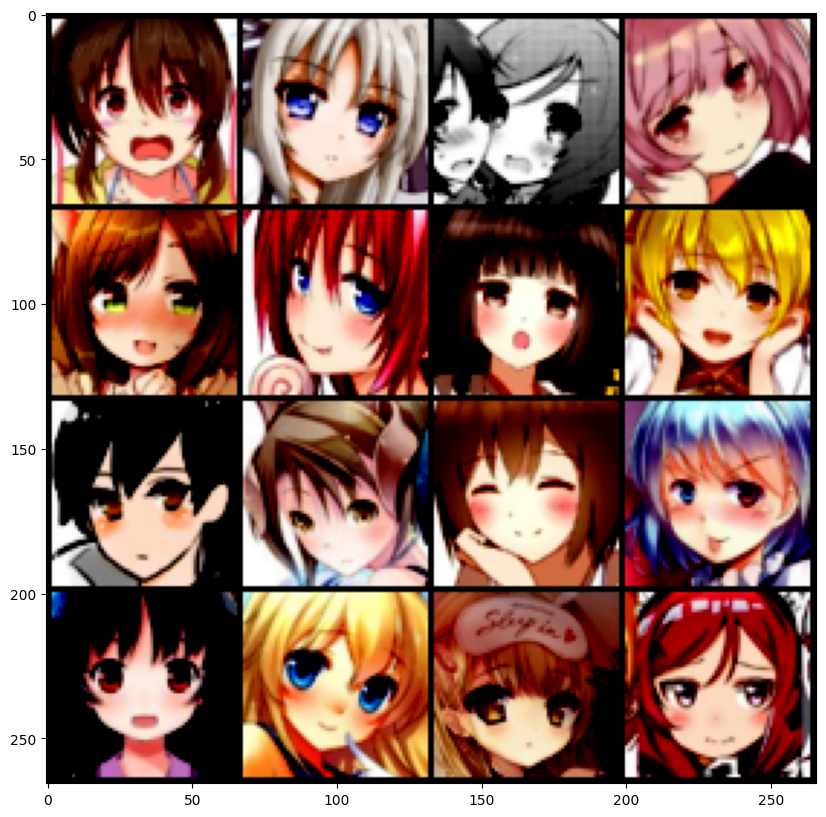

In [ ]:
dataset = CrypkoDataset()
images = [dataset[i] for i in range(16)]
# print(images[0][0][0][0],type(images[0][0][0][0].item()))
grid_img = torchvision.utils.make_grid(images, nrow=4)
plt.figure(figsize=(10,10))
out = grid_img.permute(1, 2, 0)
plt.imshow(out)
plt.show()

In [4]:
import torch.nn as nn
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)
class Generator(nn.Module):
    def __init__(self, in_dim, dim=64):
      super().__init__()
      self.indim = in_dim
      self.dim = dim
      def dconv_bn_relu(in_dim, out_dim):
            return nn.Sequential(
                nn.ConvTranspose2d(in_dim, out_dim, 5, 2,
                          padding=2, output_padding=1, bias=False),
                nn.BatchNorm2d(out_dim),
                nn.ReLU())
      self.l1 = nn.Sequential(
            nn.Linear(self.indim, self.dim * 8 * 4 * 4, bias=False),
            nn.BatchNorm1d(self.img_dim * 8 * 4 * 4),
            nn.ReLU())
      self.l2_5 = nn.Sequential(
            dconv_bn_relu(self.dim * 8, self.dim * 4),
            dconv_bn_relu(self.dim * 4, self.dim * 2),
            dconv_bn_relu(self.dim * 2, self.dim),
            nn.ConvTranspose2d(self.dim, 3, 5, 2, padding=2, output_padding=1),
            nn.Tanh()
        )
      self.apply(weights_init)
    def forward(self,x):
      y = self.l1(x)
      batch_size = y.size(0)
      dconv_dim = self.dim*8
      y = y.view(batch_size,dconv_dim,4,4)
      y = self.l2_5(y)
      return y
class Print(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, x):
      print(x.shape)
      return x
class Discriminator(nn.Module):
    """
    Input shape: (N, 3, 64, 64)
    Output shape: (N, )
    """
    def __init__(self, in_dim, dim=64):
        super().__init__()

        def conv_bn_lrelu(in_dim, out_dim):
            return nn.Sequential(
                nn.Conv2d(in_dim, out_dim, 5, 2, 2),
                nn.BatchNorm2d(out_dim),
                nn.LeakyReLU(0.2),
            )

        """ Medium: Remove the last sigmoid layer for WGAN. """
        self.ls = nn.Sequential(
            nn.Conv2d(in_dim, dim, 5, 2, 2),
            Print(),
            nn.LeakyReLU(0.2),
            conv_bn_lrelu(dim, dim * 2),
            Print(),
            conv_bn_lrelu(dim * 2, dim * 4),
            Print(),
            conv_bn_lrelu(dim * 4, dim * 8),
            Print(),
            nn.Conv2d(dim * 8, 1, 4),
            Print(),
            nn.Sigmoid(),
        )
        # self.apply(weights_init)

    def forward(self, x):
        y = self.ls(x)
        y = y.view(-1)
        return y

In [8]:
import torch
model = Discriminator(3)
test = torch.rand(32,3,64,64)
out = model(test)

torch.Size([32, 64, 32, 32])
torch.Size([32, 128, 16, 16])
torch.Size([32, 256, 8, 8])
torch.Size([32, 512, 4, 4])
torch.Size([32, 1, 1, 1])


In [ ]:
# Training hyperparameters
batch_size = 64
z_dim = 100
z_sample = Variable(torch.randn(100, z_dim)).cuda()
lr = 1e-4

""" Medium: WGAN, 50 epoch, n_critic=5, clip_value=0.01 """
n_epoch = 1 # 50
n_critic = 1 # 5
# clip_value = 0.01

log_dir = os.path.join(workspace_dir, 'logs')
ckpt_dir = os.path.join(workspace_dir, 'checkpoints')
os.makedirs(log_dir, exist_ok=True)
os.makedirs(ckpt_dir, exist_ok=True)

# Model
G = Generator(in_dim=z_dim).cuda()
D = Discriminator(3).cuda()
G.train()
D.train()

# Loss
criterion = nn.BCELoss()

""" Medium: Use RMSprop for WGAN. """
# Optimizer
opt_D = torch.optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))
opt_G = torch.optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
# opt_D = torch.optim.RMSprop(D.parameters(), lr=lr)
# opt_G = torch.optim.RMSprop(G.parameters(), lr=lr)


# DataLoader
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)


steps = 0
for e, epoch in enumerate(range(n_epoch)):
    progress_bar = qqdm(dataloader)
    for i, data in enumerate(progress_bar):
        imgs = data
        imgs = imgs.cuda()

        bs = imgs.size(0)

        # ============================================
        #  Train D
        # ============================================
        z = Variable(torch.randn(bs, z_dim)).cuda()
        r_imgs = Variable(imgs).cuda()
        f_imgs = G(z)

        """ Medium: Use WGAN Loss. """
        # Label
        r_label = torch.ones((bs)).cuda()
        f_label = torch.zeros((bs)).cuda()

        # Model forwarding
        r_logit = D(r_imgs.detach())
        f_logit = D(f_imgs.detach())

        # Compute the loss for the discriminator.
        r_loss = criterion(r_logit, r_label)
        f_loss = criterion(f_logit, f_label)
        loss_D = (r_loss + f_loss) / 2

        # WGAN Loss
        # loss_D = -torch.mean(D(r_imgs)) + torch.mean(D(f_imgs))


        # Model backwarding
        D.zero_grad()
        loss_D.backward()

        # Update the discriminator.
        opt_D.step()

        """ Medium: Clip weights of discriminator. """
        # for p in D.parameters():
        #    p.data.clamp_(-clip_value, clip_value)

        # ============================================
        #  Train G
        # ============================================
        if steps % n_critic == 0:
            # Generate some fake images.
            z = Variable(torch.randn(bs, z_dim)).cuda()
            f_imgs = G(z)

            # Model forwarding
            f_logit = D(f_imgs)

            """ Medium: Use WGAN Loss"""
            # Compute the loss for the generator.
            loss_G = criterion(f_logit, r_label)
            # WGAN Loss
            # loss_G = -torch.mean(D(f_imgs))

            # Model backwarding
            G.zero_grad()
            loss_G.backward()

            # Update the generator.
            opt_G.step()

        steps += 1

        # Set the info of the progress bar
        #   Note that the value of the GAN loss is not directly related to
        #   the quality of the generated images.
        progress_bar.set_infos({
            'Loss_D': round(loss_D.item(), 4),
            'Loss_G': round(loss_G.item(), 4),
            'Epoch': e+1,
            'Step': steps,
        })

    G.eval()
    f_imgs_sample = (G(z_sample).data + 1) / 2.0
    filename = os.path.join(log_dir, f'Epoch_{epoch+1:03d}.jpg')
    torchvision.utils.save_image(f_imgs_sample, filename, nrow=10)
    print(f' | Save some samples to {filename}.')

    # Show generated images in the jupyter notebook.
    grid_img = torchvision.utils.make_grid(f_imgs_sample.cpu(), nrow=10)
    plt.figure(figsize=(10,10))
    plt.imshow(grid_img.permute(1, 2, 0))
    plt.show()
    G.train()

    if (e+1) % 5 == 0 or e == 0:
        # Save the checkpoints.
        torch.save(G.state_dict(), os.path.join(ckpt_dir, 'G.pth'))
        torch.save(D.state_dict(), os.path.join(ckpt_dir, 'D.pth'))